# 02. DCGAN with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST Data

In [4]:
mnist_train = datasets.MNIST(root='data/',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

len(mnist_train)

60000

In [5]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

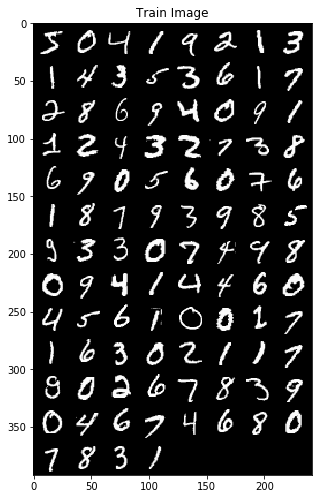

In [7]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Define Model

In [8]:
image_size = 28*28
latent_size = 100

In [9]:
# N: input, F: filter, S: stride, P: padding
def c_conv(N, F, S=1, P=0):
    return int((N+2*P-F)/S+1)

# Transposed convolution
def t_conv(N, F, S=1, P=0):
    return int(S*(N-1)+F-2*P)

In [10]:
# Encoder
c0 = 28
c1 = c_conv(c0, 4, 2, 1)
c2 = c_conv(c1, 4, 2, 1)
c3 = c_conv(c2, 4, 1, 0)
c4 = c_conv(c3, 4, 1, 0)

print(c0, c1, c2, c3, c4)

# Decoder
t0 = c4
t1 = t_conv(t0, 4, 1, 0)
t2 = t_conv(t1, 4, 1, 0)
t3 = t_conv(t2, 4, 2, 1)
t4 = t_conv(t3, 4, 2, 1)

print(t0, t1, t2, t3, t4)

28 14 7 4 1
1 4 7 14 28


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.discriminator(x)
        out = out.view(-1, 1)
        return out

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, 4, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(-1, latent_size, 1, 1)
        out = self.generator(x)
        return out

In [13]:
D = Discriminator().to(device)
G = Generator().to(device)

print(D(images.to(device)).shape)

z = torch.randn(batch_size, latent_size).to(device)
print(G(z).shape)

torch.Size([100, 1])
torch.Size([100, 1, 28, 28])


In [14]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)       
        
    return loss(x, target_tensor.to(device))

In [15]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

## Training

In [16]:
num_epochs = 100

for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        
        #-----------------------------------
        # Train D
        
        prob_real = D(images)        
        D_loss_real = gan_loss(prob_real, True)

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = (D_loss_real + D_loss_fake) / 2
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        #-----------------------------------
        # Train G
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        #-----------------------------------
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item()))

Epoch [1/100], lter [600/600], D_Loss: 0.0191, G_Loss: 4.7982
Epoch [2/100], lter [600/600], D_Loss: 0.0101, G_Loss: 6.8084
Epoch [3/100], lter [600/600], D_Loss: 0.0363, G_Loss: 10.9756
Epoch [4/100], lter [600/600], D_Loss: 0.0667, G_Loss: 8.4808
Epoch [5/100], lter [600/600], D_Loss: 0.0534, G_Loss: 1.4581
Epoch [6/100], lter [600/600], D_Loss: 0.0152, G_Loss: 2.5536
Epoch [7/100], lter [600/600], D_Loss: 0.0381, G_Loss: 8.4790
Epoch [8/100], lter [600/600], D_Loss: 0.0626, G_Loss: 1.1264
Epoch [9/100], lter [600/600], D_Loss: 0.0521, G_Loss: 6.2403
Epoch [10/100], lter [600/600], D_Loss: 0.1366, G_Loss: 5.3087
Epoch [11/100], lter [600/600], D_Loss: 0.1391, G_Loss: 7.5682
Epoch [12/100], lter [600/600], D_Loss: 0.0677, G_Loss: 6.1899
Epoch [13/100], lter [600/600], D_Loss: 0.0802, G_Loss: 4.8874
Epoch [14/100], lter [600/600], D_Loss: 0.1100, G_Loss: 6.4632
Epoch [15/100], lter [600/600], D_Loss: 0.1342, G_Loss: 5.9832
Epoch [16/100], lter [600/600], D_Loss: 0.1126, G_Loss: 4.9026


## Generate Image

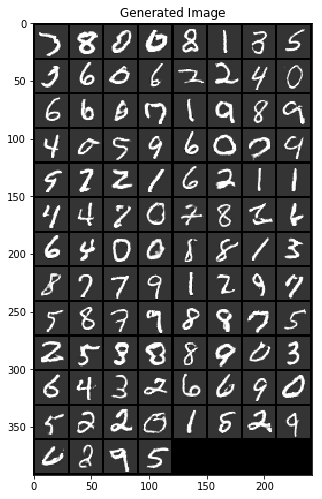

In [17]:
z = torch.randn(batch_size, latent_size).to(device)   
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Generated Image")

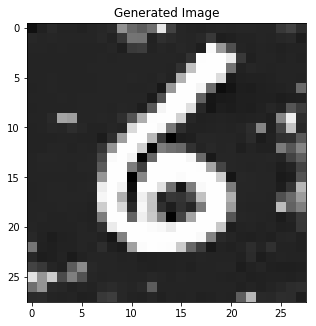

In [20]:
image = G(z[80])
imshow(torchvision.utils.make_grid(image.data.cpu(), normalize=True), "Generated Image")